In [2]:
!pip install requests beautifulsoup4 pandas matplotlib seaborn numpy
!pip install mock
!pip install --upgrade numexpr

Requirement already up-to-date: numexpr in d:\programdata\anaconda3\lib\site-packages (2.8.6)


In [78]:
import requests
import time
from bs4 import BeautifulSoup

def get_steam_game_details(appid):
    """Fetch game details from Steam API"""
    url = f"https://store.steampowered.com/api/appdetails?appids={appid}&cc=us"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        if data[str(appid)]['success']:
            game_data = data[str(appid)]['data']
            
            price_overview = game_data.get("price_overview", None)
            print("✅ Price for "+ game_data['name'])
            if price_overview:
                # Check if USD price is available
                if price_overview["currency"] != "USD": 
                    print(f"❌ {game_data['name']} price was not in USD")
            
            
            return {
                "name": game_data.get("name", "Unknown"),
                "release_date": game_data.get("release_date", {}).get("date", "Unknown"),
                "price": game_data.get("price_overview", {}).get("final", 0) / 100,  # Convert cents to dollars
                "reviewCount": game_data["recommendations"]["total"]
           }
    return None

In [79]:
import numpy as np

def estimate_revenue(review_count, price, multiplier_range=(20, 50)):
    """Estimate game revenue based on review count and price"""
    sales_low = review_count * multiplier_range[0]
    sales_high = review_count * multiplier_range[1]
    revenue_low = sales_low * price
    revenue_high = sales_high * price
    return revenue_low, revenue_high

In [87]:
# Load CSV containing AppIDs
try:
    game_appids = pd.read_csv("2024 top Releases.csv")
except Exception as e:
    print(f"❌ Error reading input CSV: {e}")

if "AppID" not in game_appids.columns:
    print("❌ CSV file must contain an 'AppID' column.")

game_data = []

for appid in game_appids["AppID"]:
    print(f"Fetching data for AppID {appid}...")
    
    details = get_steam_game_details(appid)
    if details:
        
        revenue_low, revenue_high = estimate_revenue(details["reviewCount"], details["price"])

        game_data.append({
            "Game": details["name"],
            "AppID": appid,
            "Release Date": details["release_date"],
            "Price ($)": details["price"],
            "Review Count": details["reviewCount"],
            "Estimated Revenue ($)": f"{revenue_high:.0f}"
        })

import pandas as pd

if game_data:
        output_df = pd.DataFrame(game_data)
        output_df.to_csv("game_data_output.csv", index=False)
        print(output_df)



Fetching data for AppID 2379780...
✅ Price for Balatro
Fetching data for AppID 3146520...
✅ Price for WEBFISHING
Fetching data for AppID 526870...
✅ Price for Satisfactory
Fetching data for AppID 1040200...
✅ Price for Crime Scene Cleaner
Fetching data for AppID 2198150...
✅ Price for Tiny Glade
Fetching data for AppID 1043810...
✅ Price for Tactical Breach Wizards
Fetching data for AppID 629730...
✅ Price for Blade and Sorcery
Fetching data for AppID 1895350...
✅ Price for I Wani Hug that Gator!
Fetching data for AppID 1746030...
✅ Price for Murders on the Yangtze River
Fetching data for AppID 3107330...
✅ Price for Nodebuster
Fetching data for AppID 2704110...
✅ Price for Aliya: Timelink
Fetching data for AppID 1996010...
✅ Price for Crow Country
Fetching data for AppID 2835570...
✅ Price for Buckshot Roulette
Fetching data for AppID 2299900...
✅ Price for Felvidek
Fetching data for AppID 2111190...
✅ Price for MULLET MADJACK
Fetching data for AppID 1876590...
✅ Price for I Am Your B

🔢 8.33% of the games account for 80.0% of the total revenue.
📊 58 out of 108 games (53.70%) made more than $1,000,000 in revenue.


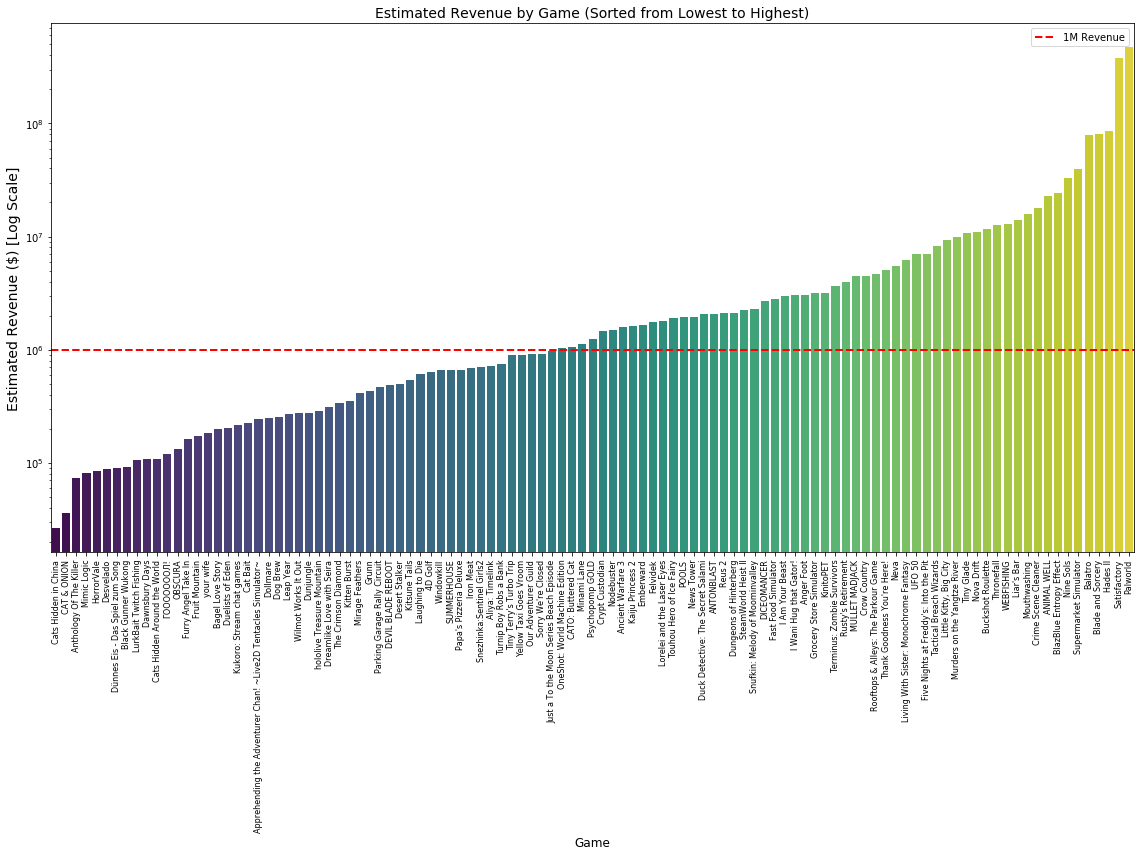

In [9]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CSV file
df = pd.read_csv("game_data_output.csv")

# Convert Estimated Revenue ($) to a numeric value (taking the high end of the estimate)
df["Estimated Revenue ($)"] = df["Estimated Revenue ($)"].astype(float)


df_sorted = df

ignore_top_n = 0

# Ignore the top N highest-earning games
if ignore_top_n > 0:
    # Sort by revenue (highest to lowest)
    df_sorted = df.sort_values(by="Estimated Revenue ($)", ascending=True)
    df_sorted = df_sorted.iloc[ignore_top_n:]

# Sort by revenue (highest first)
df_sorted = df_sorted.sort_values(by="Estimated Revenue ($)", ascending=True)  # Lowest first


percent_target = 80.0

# Power Law Calculation - Find the % of games making `percent_target`% of revenue
total_revenue = df_sorted["Estimated Revenue ($)"].sum()
target_revenue = (percent_target / 100) * total_revenue

cumulative_revenue = 0
game_count = 0

for revenue in df_sorted["Estimated Revenue ($)"].sort_values(ascending=False):
    cumulative_revenue += revenue
    game_count += 1
    if cumulative_revenue >= target_revenue:
        break

percentage_of_games = (game_count / len(df_sorted)) * 100

print(f"🔢 {percentage_of_games:.2f}% of the games account for {percent_target}% of the total revenue.")


# Calculate percentage of games earning over $1M
total_games = len(df_sorted)
games_over_1m = len(df_sorted[df_sorted["Estimated Revenue ($)"] > 1_000_000])
percentage_over_1m = (games_over_1m / total_games) * 100 if total_games > 0 else 0

print(f"📊 {games_over_1m} out of {total_games} games ({percentage_over_1m:.2f}%) made more than $1,000,000 in revenue.")


# Set up figure size
plt.figure(figsize=(16, 12))  # Larger image for clarity

# Plot
sns.barplot(x=df_sorted["Game"], y=df_sorted["Estimated Revenue ($)"], palette="viridis")


draw1MilLowestBound = True
# Add red horizontal line at $1,000,000 revenue
if draw1MilLowestBound: 
    plt.axhline(y=1_000_000, color="red", linestyle="--", linewidth=2, label="1M Revenue")


# Formatting
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Game", fontsize=12)
plt.ylabel("Estimated Revenue ($)", fontsize=12)
plt.title("Estimated Revenue by Game (Sorted from Lowest to Highest)", fontsize=14)

plt.legend()

log_scale = True

# Apply logarithmic scale if enabled
if log_scale:
    plt.yscale("log")
    plt.ylabel("Estimated Revenue ($) [Log Scale]", fontsize=14)


# Save the figure as a high-resolution image
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig("estimated_revenue_chart_top_20.png", dpi=300)  # Save as a 300 DPI image

plt.show()


In [15]:
from PIL import Image
import os

def convert_png_to_jpeg(folder_path):
    """
    Converts all PNG files in the specified folder to JPEG format with the same name.
    
    Parameters:
    - folder_path (str): Path to the folder containing PNG files to be converted.
    """
    
    # List all files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            # Construct the full path to the file
            png_file_path = os.path.join(folder_path, filename)
            jpeg_file_path = os.path.join(folder_path, filename.replace(".png", ".jpg"))
            
            # Open the PNG image
            with Image.open(png_file_path) as img:
                # Convert and save as JPEG
                img.convert("RGB").save(jpeg_file_path, "JPEG", quality=95)
                print(f"Converted: {filename} -> {jpeg_file_path}")

# Example Usage: Replace with your folder path
convert_png_to_jpeg("E:\PlayGround\SteamScrap")

Converted: estimated_revenue_chart_top_20.png -> E:\PlayGround\SteamScrap\estimated_revenue_chart_top_20.jpg
Converted: revenue_by_month_2024.png -> E:\PlayGround\SteamScrap\revenue_by_month_2024.jpg


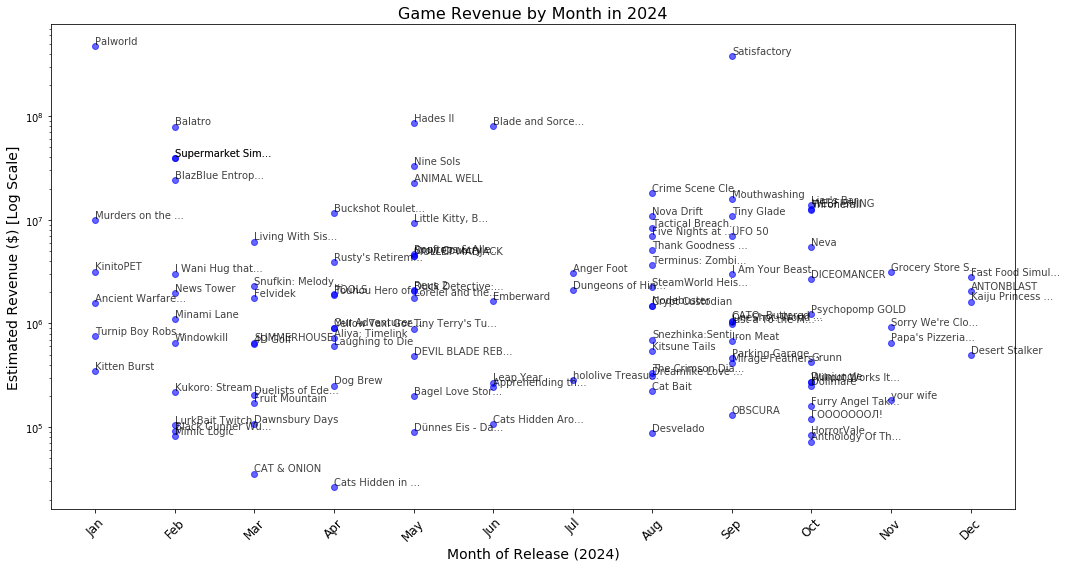

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

def plot_revenue_by_month(csv_file, log_scale=False):
    """
    Plots game revenue distribution over months in 2024.
    
    - X-axis: Months of 2024.
    - Y-axis: Estimated revenue.
    - Dots represent games released in that month.
    - Option for logarithmic Y-axis scaling.

    Parameters:
    - csv_file (str): Path to the CSV file with game data.
    - log_scale (bool): If True, scales the Y-axis logarithmically.
    """

    # Load data
    df = pd.read_csv(csv_file)

    # Convert release date to datetime format
    df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")

    # Filter for games released in 2024
    df = df[df["Release Date"].dt.year == 2024]

    # Convert revenue column to numeric
    df["Estimated Revenue ($)"] = df["Estimated Revenue ($)"].replace('[\$,]', '', regex=True).astype(float)

    # Extract the month of release
    df["Release Month"] = df["Release Date"].dt.month

    # Mapping months to readable names
    month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # Create the scatter plot
    plt.figure(figsize=(15, 8))
    plt.scatter(df["Release Month"], df["Estimated Revenue ($)"], color="blue", alpha=0.6)
    name_length = 15
    # Add truncated game names next to the dots
    for i, row in df.iterrows():
        truncated_name = row["Game"][:name_length] + "..." if len(row["Game"]) > name_length else row["Game"]
        plt.text(row["Release Month"], row["Estimated Revenue ($)"], truncated_name, fontsize=10, ha="left", va="bottom", alpha=0.75)

    # Labels and formatting
    plt.xticks(range(1, 13), month_labels, rotation=45, fontsize=12)
    plt.xlabel("Month of Release (2024)", fontsize=14)
    plt.ylabel("Estimated Revenue ($)", fontsize=14)
    plt.title("Game Revenue by Month in 2024", fontsize=16)

    # Apply log scale if enabled
    if log_scale:
        plt.yscale("log")
        plt.ylabel("Estimated Revenue ($) [Log Scale]", fontsize=14)

    # Save as high-resolution PNG
    plt.tight_layout()
    plt.savefig("revenue_by_month_2024.png", dpi=300)

    plt.show()

# Example Usage
plot_revenue_by_month("game_data_output.csv", log_scale=True)